In [39]:
import re
import string
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import yaml
from calculate import calculate_compound
from coulson.interface import mol_from_xyz
from rdkit import Chem
from utils import (
    add_to_variables,
    format_dictionary_for_yaml,
    load_garner,
    plot_zero_zero,
)

plt.style.use("default")

Load the paths

In [25]:
path_data_na = snakemake.input.data_non_alternants
path_ref_na = snakemake.input.reference_non_alternants

path_data_as = snakemake.input.data_avoided_symmetry
path_ref_as = snakemake.input.reference_avoided_symmetry

path_data_sub = snakemake.input.data_substituted
path_ref_sub = snakemake.input.reference_substituted

path_xyz_na = snakemake.input.xyz_non_alternants
path_xyz_as = snakemake.input.xyz_avoided_symmetry
path_xyz_sub = snakemake.input.xyz_substituted

path_lc = snakemake.input.corr

Open the dataframes

In [26]:
df_na = load_garner(path_data_na, path_ref_na, path_lc)
df_as = load_garner(path_data_as, path_ref_as, path_lc)
df_sub = load_garner(path_data_sub, path_ref_sub, path_lc)

Check which compounds overlap

In [27]:
path_rational = snakemake.input.reference_rational
df_rational = pd.read_csv(path_rational, index_col=0)

In [28]:
df_rational["smiles_canon"] = df_rational["smiles"].apply(
    lambda x: Chem.MolToSmiles(Chem.MolFromSmiles(x))
)

In [29]:
for name, df, path in (
    ("non_alternants", df_na, path_xyz_na),
    ("avoided_symmetry", df_as, path_xyz_as),
    ("substituted", df_sub, path_xyz_sub),
):
    canon_smiles = []
    for i, row in df.iterrows():
        mol = mol_from_xyz(f"{path}/{i}.xyz")
        smiles = Chem.MolToSmiles(Chem.RemoveHs(mol))
        canon_smiles.append(smiles)
    df["smiles_canon"] = canon_smiles

In [30]:
df_overlap_na = pd.merge(df_na, df_rational, how="inner", on=["smiles_canon"])
df_overlap_as = pd.merge(df_as, df_rational, how="inner", on=["smiles_canon"])
df_overlap_sub = pd.merge(df_sub, df_rational, how="inner", on=["smiles_canon"])

In [31]:
df_overlap_all = pd.concat([df_overlap_sub, df_overlap_na, df_overlap_as])
print("Number of duplicates:", df_overlap_all.duplicated(subset="smiles_canon").sum())
df_overlap_all_nodup = df_overlap_all.drop_duplicates()
df_overlap_all_nodup["smiles_canon"]

Number of duplicates: 5


0     NC1=CC=CC(N)=C2C(N)=CC=CC(N)=C12
1                 NC1=NC(N)=C2C=CC=C12
2         NC1=Cc2cc3c(cc2=C1)C=C(N)C=3
3         Nc1c2c(c(N)c3c1=CC=C3)=CC=C2
4                     C1=NC=C2C=NC=C12
5                 NC1=CC(N)=C2C=CC=C12
6           NC1=NC(N)=C2C(N)=NC(N)=C12
7                 NC1=CC2=CC(N)=CC2=C1
8           NC1=CC(N)=C2C(N)=CC(N)=C12
9     N#CC1=Cc2cc3c(cc2=C1)C=C(C#N)C=3
10    NC1=CC(N)=c2cc3c(cc21)=C(N)C=C3N
11                NC1=NC(N)=C2C=NC=C12
0               C1=CC=C2C=CC=CC=C2C=C1
1                 c1ccc2ccc3cccc3c2cc1
2                      c1ccc2cccc-2cc1
3                     C1=CC2=CC=CC2=C1
4                 c1ccc2cc3cccc3cc2cc1
5             C1=Cc2cc3c(cc2=C1)C=CC=3
0                 c1ccc2cc3cccc3cc2cc1
1             C1=Cc2cc3c(cc2=C1)C=CC=3
2               C1=CC=C2C=CC=CC=C2C=C1
3               C1=CC=C2C=CC=CC=C2C=C1
4                     C1=CC2=CC=CC2=C1
Name: smiles_canon, dtype: object

Investigate failure modes for substituted compounds

P with degree 4 is not implemented!


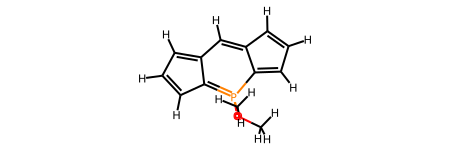

P with degree 4 is not implemented!


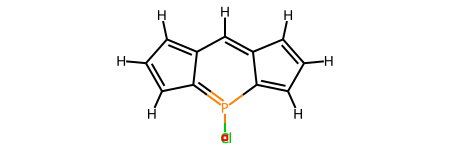

P with degree 4 is not implemented!


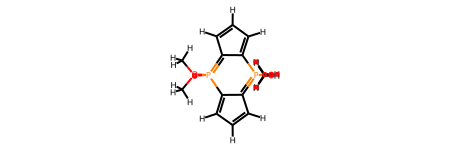

P with degree 4 is not implemented!


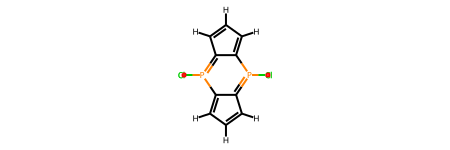

In [34]:
df = pd.read_csv(path_data_sub)
df[df.isna().any(axis=1)]

for i, row in df[df.isna().any(axis=1)].iterrows():
    path_xyz = f"{path_xyz_sub}/{row['id']}.xyz"
    mol = mol_from_xyz(path_xyz)
    try:
        calculate_compound(path_xyz)
    except Exception as e:
        print(e)
    display(mol)

Plot the data

In [60]:
variables = {}
params = {}

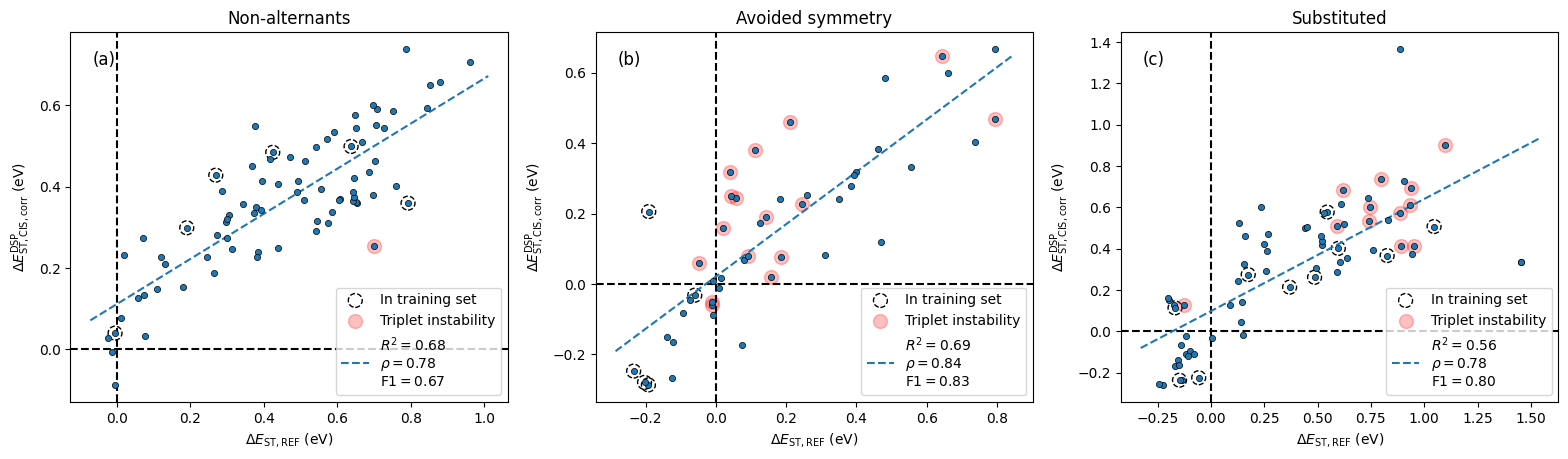

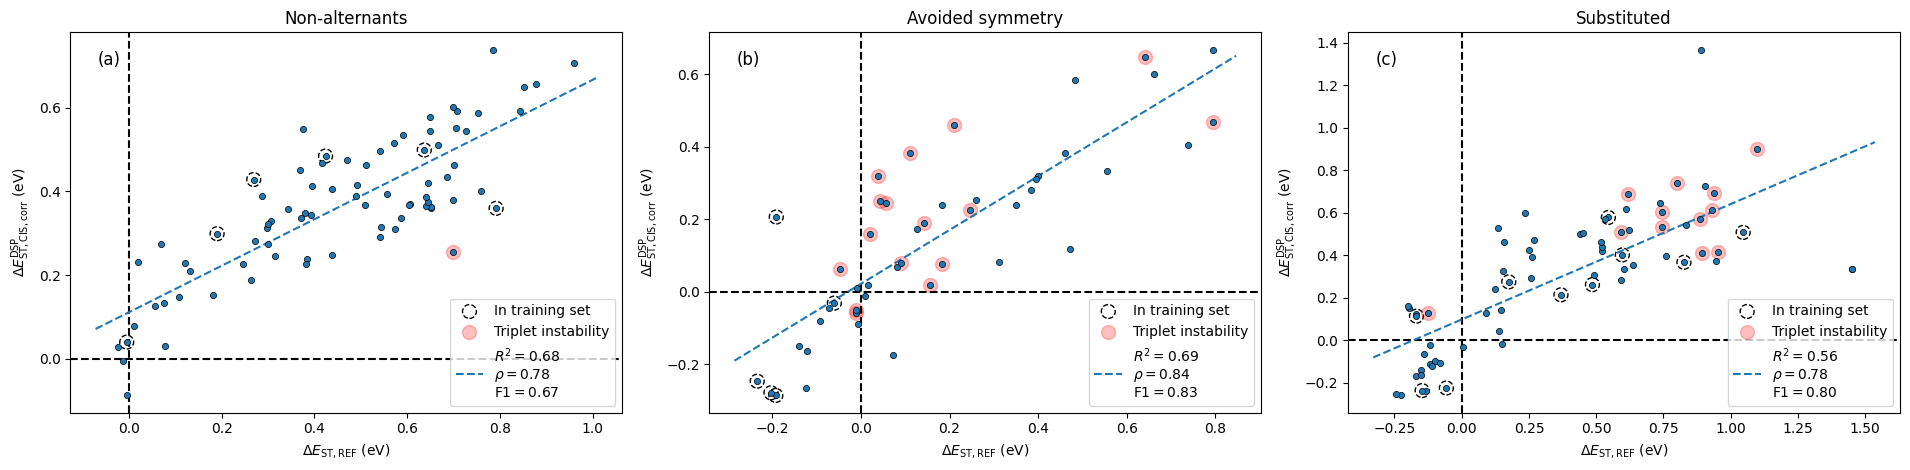

In [63]:
plot_kwargs = {"edgecolors": "black", "linewidths": 0.5}

fig, ax = plt.subplots(1, 3, figsize=plt.rcParams["figure.figsize"] * np.array([3, 1]))

# Create subfigure labels
for i, ax_ in enumerate(ax):
    label = string.ascii_lowercase[i]
    ax_.text(
        0.05,
        0.95,
        f"({label})",
        fontsize="large",
        transform=ax_.transAxes,
        verticalalignment="top",
    )

jobs = (
    ("Non-alternants", df_na, df_overlap_na),
    ("Avoided symmetry", df_as, df_overlap_as),
    ("Substituted", df_sub, df_overlap_sub),
)


all_results = {}
x_name = "t1_s1_cc2_aug_dz"
y_name = "t1_s1_dsp_cis_corr"
for i, (label, df, df_overlap) in enumerate(jobs):
    df_overlap.dropna(subset=[x_name, y_name]).plot.scatter(
        x=x_name,
        y=y_name,
        linestyle="--",
        edgecolors="black",
        c="none",
        s=100,
        ax=ax[i],
        zorder=0,
        label="In training set",
    )

    df[df["instability"] == True].dropna(subset=[x_name, y_name]).plot.scatter(
        x=x_name,
        y=y_name,
        c="red",
        alpha=0.25,
        s=100,
        ax=ax[i],
        zorder=0,
        label="Triplet instability",
    )
    _, _, results = plot_zero_zero(
        df.dropna(subset=[x_name, y_name]),
        x_name=x_name,
        y_name=y_name,
        ax=ax[i],
        legend_loc="lower right",
        **plot_kwargs,
    )

    ax[i].set_title(label)

    all_results[label] = results
display(fig)

fig.tight_layout()
path_figure = snakemake.output.figure_gaps
variables[f"fig_garner_gaps"] = "../" + str(Path(path_figure).with_suffix(""))
fig.savefig(path_figure)

# Add results to variables
for label, results in all_results.items():
    variables = add_to_variables(
        variables,
        results,
        label_calculation="garner",
        label_compound="gaps",
        label_method="_".join(re.split(" |-", label.lower())),
    )

# Add parameters to be saved
path_table = snakemake.output.table_gaps
params[f"tab_garner_gaps"] = "../" + path_table

# Print tables for the paper
df = pd.DataFrame(all_results).T
floatfmt = [None] + [".2f"] * (len(results) - 4) + [".0f"] * 4
df.to_markdown(path_table, floatfmt=floatfmt)

Save data to file

In [64]:
with open(snakemake.output.params, "w") as f:
    yaml.dump(format_dictionary_for_yaml(params, n_dec=2), f)
with open(snakemake.output.variables, "w") as f:
    yaml.dump(format_dictionary_for_yaml(variables, n_dec=2), f)